In [ ]:
#!pip3 install skimpy

In [1]:
import pandas as pd
import numpy as np
from threading import Thread
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as se

from skimpy import skim
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import faiss
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
import random
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\envs\practicum\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load data

- *base.csv* - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- *target.csv -* обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из *base.csv*, который максимально похож на него (по мнению экспертов).
- *validation.csv* - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из *base.csv*
- *validation_answer.csv* - правильные ответы к предыдущему файлу.

Загрузим данные из base и target. Посмотрим как они выглядят, есть ли очень большие выбросы и т.д. 

## Base data

In [55]:
df_base = pd.read_csv("data/base.csv", index_col=0)

In [3]:
df_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [19]:
df_base.shape

(2918139, 72)

In [20]:
print("Количество уникальных индексов: ", len(df_base.index.unique()))

Количество уникальных индексов:  2918139


In [6]:
#skim(df_base)

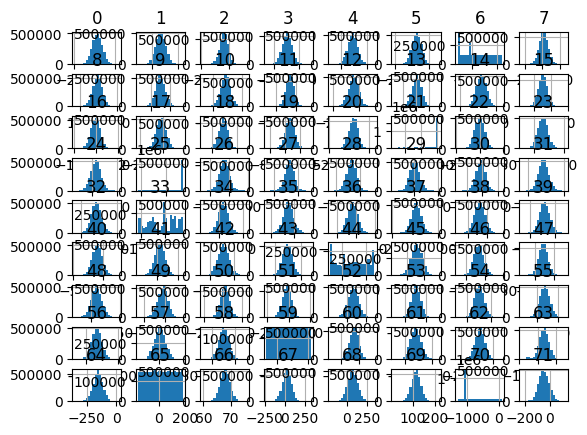

In [7]:
df_base.hist(bins=20)
print()

In [56]:
bad_features= ['6', '21', '25', '44', '59', '70', '65']

In [57]:
df_base.drop(bad_features, axis=1, inplace=True)

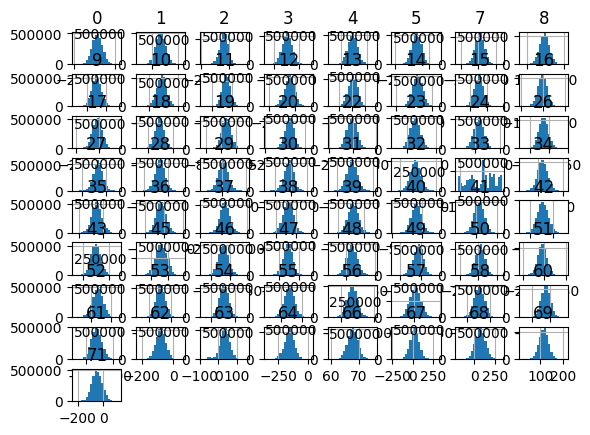

In [23]:
df_base.hist(bins=20)
print()

## Train data

In [58]:
df_train = pd.read_csv("data/train.csv", index_col=0)
df_train.drop(bad_features, axis=1, inplace=True)

In [25]:
df_train.shape

(100000, 66)

In [26]:
df_train.head()

,0,1,2,3,4,5,7,8,9,10,...,61,62,63,64,66,67,68,69,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,38.307602,109.085560,30.413513,-88.08269,...,-132.38617,-105.427820,70.107360,-155.80257,65.903790,34.457500,62.642094,134.763600,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-78.433090,124.915900,140.331070,-177.60580,...,-137.41136,-40.812233,4.669178,-151.69771,68.170876,25.096191,89.974976,130.589630,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,-30.447489,125.771164,211.607820,-86.34656,...,-139.22307,-52.031662,78.039764,-169.14620,66.008220,18.400496,212.409730,121.931470,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,79.186520,124.003100,242.650650,-146.51707,...,-131.19829,-61.567047,44.515266,-145.41675,64.131350,106.061920,83.178760,118.277725,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,45.984676,125.941284,103.392670,-107.15302,...,-103.34170,-68.770600,45.028910,-196.09207,66.926220,42.456170,77.621765,92.479930,-21.149351,717819-base


In [27]:
#skim(df_train)

In [59]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

## Validation data

In [60]:
df_validation = pd.read_csv("data/validation.csv", index_col=0)
df_validation_answer = pd.read_csv("data/validation_answer.csv", index_col=0)

In [11]:
df_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


In [12]:
df_validation_answer.head()

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


In [61]:
df_validation.drop(bad_features, axis=1, inplace=True)

# Подготовка данных

## Уменьшение размерности

In [23]:
pca = PCA(n_components=12)
df_base_pca = pca.fit_transform(df_base)
df_train_pca = pca.fit_transform(df_train)
df_validation_pca = pca.fit_transform(df_validation)

## Масштабирование

In [42]:
multi_index_base

,Kmean_0,Kmean_1,Kmean_2,Kmean_3,Kmean_4
0,9,33,38,30,30
1,38,45,21,39,8
2,46,46,45,4,16
3,37,44,11,37,14
4,4,25,1,22,7
...,...,...,...,...,...
2918134,27,43,0,3,48
2918135,48,37,0,18,6
2918136,27,10,47,0,15
2918137,32,14,46,45,40


In [99]:
multi_index_base.index = df_base.index
multi_index_train.index = df_train.index

In [100]:
df_base1 = pd.concat([df_base, multi_index_base], axis = 1)
df_train1 = pd.concat([df_train, multi_index_train], axis = 1)

In [101]:
scale = StandardScaler()
base_scaled = scale.fit_transform(df_base1)
train_scaled = scale.transform(df_train1)
#validation_scaled = scale.transform(df_validation)

In [72]:
df_base1

,0,1,2,3,4,5,7,8,9,10,...,66,67,68,69,71,Kmean_0,Kmean_1,Kmean_2,Kmean_3,Kmean_4
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,44.348083,120.915344,181.449700,-124.06151,...,63.666340,-4.703861,92.933610,115.269190,-60.830353,9,33,38,30,30
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-35.637436,119.718636,195.234190,-141.30435,...,68.202110,24.346846,179.937930,116.834000,-59.524610,38,45,21,39,8
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,62.381706,128.951450,164.381470,-140.82245,...,65.566180,66.325680,81.073490,116.594154,-32.527206,46,46,45,4,16
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-33.611237,122.031910,136.233580,-108.47044,...,66.202890,-20.566910,137.206940,117.474100,-72.915490,37,44,11,37,14
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,45.182500,122.167180,112.119064,-110.34245,...,66.766320,-2.505783,65.315285,135.051590,0.319401,4,25,1,22,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744755-base,-125.086300,4.735448,38.284935,-125.27671,209.788360,-47.870010,-71.077340,125.534355,29.341850,-99.02736,...,65.515260,108.963715,-52.795380,117.254510,-77.768555,27,43,0,3,48
4744759-base,-108.598390,5.454173,-22.191975,-158.71666,113.606110,-88.843430,137.317690,129.056690,164.754240,-153.49846,...,68.691666,1.636499,-24.388298,93.530540,-90.800400,48,37,0,18,6
4744762-base,-97.026730,-2.143885,-71.274090,-144.68066,149.464810,-21.572212,-108.151955,124.810135,118.760700,-110.06689,...,68.592970,43.205433,69.029830,129.536650,4.718300,27,10,47,0,15


## Оценка количества кластеров

Количесвто кластеров можно оценить с момощью Kmean и его встроенного отрибута *inertia_*, который считает сумму квадратов расстояний от образцов до центра их кластера. Получим зависимоть значений *inertia_* от количесвта кластеров, апроксимируем полученное соотношение. Далее найдем оптимельное количесвто класстеров, когда производная перестанет сильно изменяться. 

In [16]:
err = []
n_clusters = [10, 50, 100, 200, 500, 750, 1000]
for i in n_clusters:
    kmeans = KMeans(n_clusters = i, init='k-means++', n_init=5, random_state=42)
    kmeans.fit(base_scaled[:100000])
    print(kmeans.inertia_)
    err.append(kmeans.inertia_)

5999978.4956884375
5103622.873734475
4605522.496235655
4192240.0066745896
3732242.3671705294
3543752.858484758
3406775.9407190653


(0.0, 1000.0)

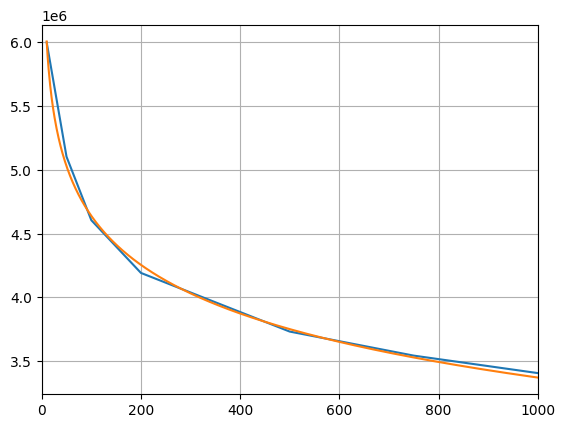

In [23]:
apoc_func = lambda x: 7.14475E6-5.46356E5*np.log(x-1.97824)
plt.plot(n_clusters, err, [i for i in range(10, 1000)], [apoc_func(i) for i in range(10, 1000)])
plt.grid()
plt.xlim(0, 1000)

Посмотрим на производную от апроксимирующей функции 

(0.0, 1000.0)

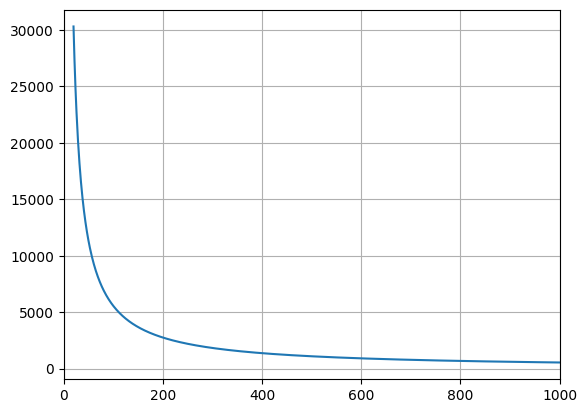

In [24]:
prime_func = lambda x: -5.46356E5/(x-1.97824)
plt.plot([i for i in range(20, 1000)], [abs(prime_func(i)) for i in range(20, 1000)])
plt.grid()
plt.xlim(0, 1000)

Производная от ошибки слабо уменьшается после 150-200 кластеров

  0%|          | 0/13 [00:00<?, ?it/s]

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\practicum\lib\site-packages\numpy\core\multiarray.py", line 346, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\practicum\lib\site-packages\numpy\core\multiarray.py", line 346, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\practicum\lib\site-packages\numpy\core\multiarray.py", line 346, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
KeyboardInterrupt: 


KeyboardInterrupt: 

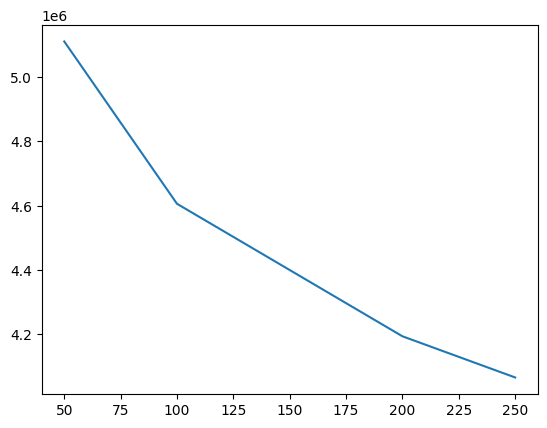

In [25]:
#Проверим ведет ли себя также ошибка на других частях датасета

# sum_err = []
# for j in tqdm(range((len(df_base)//100000)//2-1)):
#     err = []
#     n_clusters = [50, 100, 200, 250]
#     for i in n_clusters:
#         kmeans = KMeans(n_clusters = i, init='k-means++', n_init=4, random_state=42)
#         kmeans.fit(base_scaled[100000*j*2:100000*(j*2+1)])
#         err.append(kmeans.inertia_)
#     plt.plot(n_clusters, err)
#     sum_err.append(err)
# plt.show()

*Вывод ячейки выше. Если пересчитать картинка будет немного отличаться по оси ординат*
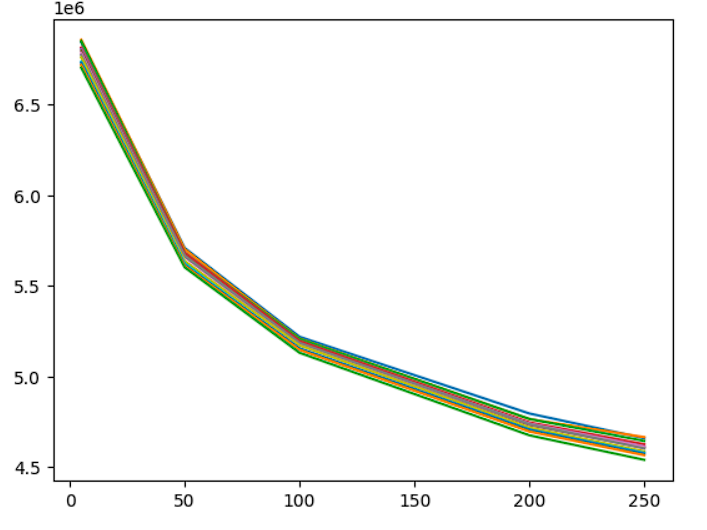

### Вывод

При значении 200, производная резко уменьшаться.

## Визуализация

In [45]:
kmeans = KMeans(n_clusters = 200)
cluster = kmeans.fit_predict(base_scaled[:100000])

In [27]:
tsne2D = TSNE(n_components=2)
tsne_data2D = tsne2D.fit_transform(base_scaled[:100000])

In [28]:
tsne2D_df = pd.DataFrame(data = tsne_data2D, columns=['x', 'y'])

In [46]:
tsne2D_df['cluster'] = cluster

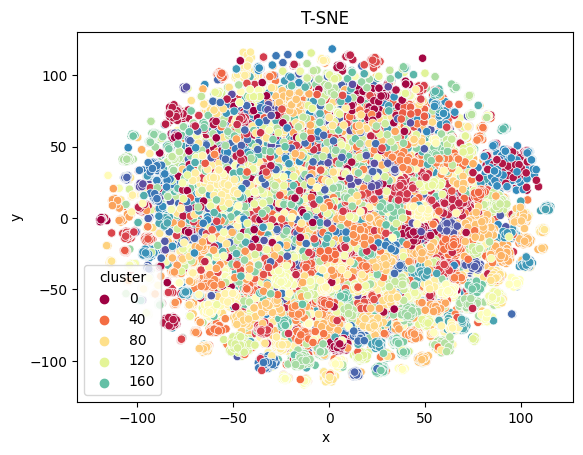

In [47]:
se.scatterplot(x='x', y='y',hue='cluster', data=tsne2D_df, palette="Spectral")
plt.title("T-SNE")
plt.show()

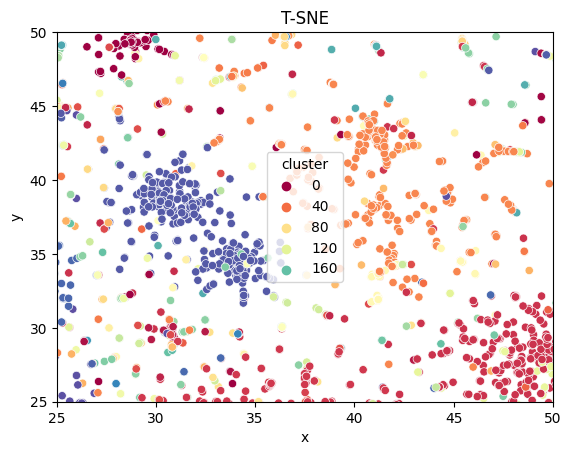

In [48]:
se.scatterplot(x='x', y='y',hue='cluster', data=tsne2D_df, palette="Spectral")
plt.title("T-SNE")
plt.xlim(25, 50)
plt.ylim(25, 50)
plt.show()

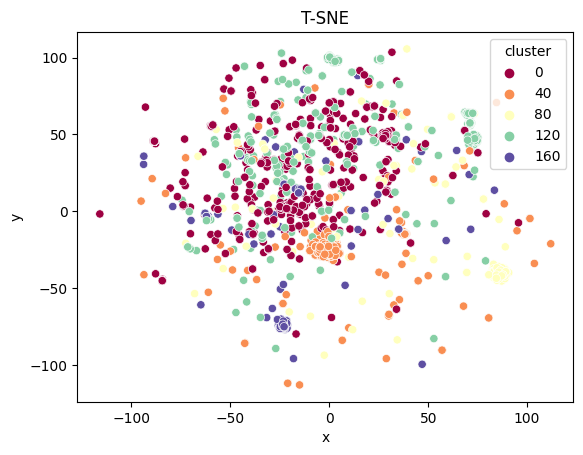

In [49]:
se.scatterplot(x='x', y='y',hue='cluster', data=tsne2D_df.query("cluster %40 == 0"), palette="Spectral")
plt.title("T-SNE")
plt.show()

Есть данные которые можно очень хорошо разделить на кластеры, а есть звёздное небо...

# Обучение

## Nearest Neighbors (scikit-learn)

In [194]:
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(base_scaled)

NearestNeighbors()

In [195]:
ans = neigh.kneighbors(train_scaled, 5, return_distance=False)

In [196]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [197]:
acc = 0
for target, el in zip(targets.values.tolist(), ans.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(ans))

68.615


## Faiss


### Create index

In [102]:
dims = base_scaled.shape[1]
n_cells = 1000
# how many cells
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells, faiss.METRIC_L2)
idx_l2.nprobe = 10

In [103]:
idx_l2.train(np.ascontiguousarray(base_scaled).astype('float32'))
idx_l2.add(np.ascontiguousarray(base_scaled).astype('float32'))

In [104]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [107]:
vecs, idx = idx_l2.search(np.ascontiguousarray(train_scaled).astype('float32'), 5)

In [108]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

65.774


In [313]:
vecs

array([[1.0210138e+01, 1.3210451e+01, 1.3716598e+01, ..., 1.5467793e+01,
        1.5796886e+01, 1.6019335e+01],
       [1.3859095e+01, 1.5677731e+01, 1.7988262e+01, ..., 2.6501766e+01,
        3.0591423e+01, 3.6216198e+01],
       [1.5545465e+01, 1.9049414e+01, 1.9483135e+01, ..., 2.2399961e+01,
        2.2493275e+01, 2.3545092e+01],
       ...,
       [1.2068557e+00, 1.5768477e+00, 2.2901256e+00, ..., 2.8975265e+00,
        3.4405639e+00, 3.9815903e+00],
       [2.6338899e+00, 2.6338899e+00, 2.6338899e+00, ..., 3.5122786e+00,
        3.5122786e+00, 3.5809870e+00],
       [1.8681871e-02, 3.5635910e+01, 3.6741425e+01, ..., 4.1836720e+01,
        4.2738029e+01, 4.2761631e+01]], dtype=float32)

In [97]:
dims = base_scaled.shape[1]
m = 13
nbits = 8
idxPQ = faiss.IndexPQ(dims, m, nbits)
idxPQ.nprobe = 5

In [98]:
idxPQ.train(np.ascontiguousarray(base_scaled).astype('float32'))

idxPQ.add(np.ascontiguousarray(base_scaled).astype('float32'))

In [99]:
vecs, idx = idxPQ.search(np.ascontiguousarray(train_scaled).astype('float32'), 5)

In [100]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

65.86


In [101]:
dims = base_scaled.shape[1]
vecs = faiss.IndexFlatL2(dims)
nlist = 200  # how many Voronoi cells (must be >= k* which is 2**nbits)
nbits = 8  # when using IVF+PQ, higher nbits values are not supported
index_IVF_PQ = faiss.IndexIVFPQ(vecs, dims, nlist, m, nbits)
index_IVF_PQ.nprobe = 5

In [102]:
index_IVF_PQ.train(np.ascontiguousarray(base_scaled).astype('float32'))

index_IVF_PQ.add(np.ascontiguousarray(base_scaled).astype('float32'))

In [103]:
vecs, idx = idxPQ.search(np.ascontiguousarray(train_scaled).astype('float32'), 5)

In [104]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

65.86


In [119]:
M = 64  # number of connections each vertex will have
ef_search = 32  # depth of layers explored during search
ef_construction = 64  # depth of layers explored during index construction

# initialize index (d == 128)
index_HNSW = faiss.IndexHNSWFlat(65, M, faiss.METRIC_L2)
# set efConstruction and efSearch parameters
index_HNSW.hnsw.efConstruction = ef_construction
index_HNSW.hnsw.efSearch = ef_search
index_HNSW.
# add data to index
index_HNSW.add(np.ascontiguousarray(base_scaled).astype('float32'))

# search as usual
vecs, idx = index_HNSW.search(np.ascontiguousarray(train_scaled).astype('float32'), 5)

In [120]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

65.46


## Inverted Multi-Index

DOI 10.1109/TPAMI.2014.2361319

In [69]:
base_scaled = pd.DataFrame(base_scaled)
train_scaled = pd.DataFrame(train_scaled)

In [11]:

#kmean_dim - на сколько частей делить исходный вектор, т е размерность пространства Kmean = len(vec)/kmean_dim

class inverted_multi_index:
    
    def __init__(self, number_clusters=200, kn = 1):
        self.dim = 0
        self.clasters = []
        self.K_means = []
        self.cluster_centers = []
        self.number_clusters=number_clusters
        self.kn = kn
        self.pred = []
        self.distance_in_cluster_space = []
    
    def chunks(self, a, n):
        k, m = divmod(len(a), n)
        return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))


    #Разделяет на клстеры
    #Сохраняет координаты центройд
    #Сохроняет KMeans
    def fit(self, data: pd.DataFrame, number_rows = 100000):
        col = self.chunks(list(data.columns), self.kn)
        for i in tqdm(col):
            KM = KMeans(n_clusters = self.number_clusters)
            KM.fit(data.sample(number_rows)[i])
            self.K_means.append(KM)
            self.cluster_centers.append(KM.cluster_centers_)


    #Сохраняет в point_cluster_space данные в пространсте центройд
    def transform(self, data: pd.DataFrame): 
        self.dim = data.shape[0]
        col = self.chunks(data.columns, self.kn)
        for index, i in tqdm(enumerate(col)):
            self.distance_in_cluster_space.append(self.K_means[index].transform(data[i]))
            self.clasters.append(self.K_means[index].predict(data[i]))
        self.distance_in_cluster_space = np.array(self.distance_in_cluster_space)
            
    #Сохраняет в pred принадлежность к класетру        
    def predict_clasters(self, query: pd.DataFrame):
        col = self.chunks(query.columns, self.kn)
        for index, i in tqdm(enumerate(col)):
            self.pred.append(self.K_means[index].predict(query[i]))
    
    def sum_PQ(self, list1, list2 = np.array([])):    
        if len(list1) == 0:
            return list2 
        if not list2.size:
            b = list1[-2]
            a = list1[-1]
            list1 = np.delete(list1, -1, 0)
            list1 = np.delete(list1, -1, 0)
        else:
            b = list1[-1]
            a = list2
            list1 = np.delete(list1, -1, 0)
        res = np.array([])
        for i in a:
            for j in b:
                res = np.append(res, j+i) 
        return self.sum_PQ(list1, res)
    
    
    def product_quantization(self):
        res = np.array([])
        for j in tqdm(range(self.dim)):  
            a = sum(np.array(self.distance_in_cluster_space)[:,i])
            a = np.reshape(a, newshape=(1,-1))
            res = np.concatenate((res, a), casting='no') if res.size else a #res.append(a)
        return res
    
    def get_clasters(self):
        columns = [f"Kmean_{i}" for i in range(self.kn)]
        return pd.DataFrame(np.array(self.pred).T, columns=columns)
    
    def sum_distance(self, rows):
        
            
        return np.sum(self.distance_in_cluster_space[0])
    
    def distance_matrix(self):
        a =1

In [97]:
ivmi = inverted_multi_index(number_clusters=25, kn = 10)
ivmi.fit(df_base, number_rows = 750000)

0it [00:00, ?it/s]

In [ ]:
ivmi.transform(base_scaled)

In [ ]:
ivmi.pred = []
ivmi.predict_clasters(base_scaled)

In [98]:
ivmi.pred = []
ivmi.predict_clasters(df_train)
multi_index_train = ivmi.get_clasters()

ivmi.pred = []
ivmi.predict_clasters(df_base)
multi_index_base = ivmi.get_clasters()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [21]:
multi_index_train

,Kmean_0,Kmean_1,Kmean_2,Kmean_3,Kmean_4
0,10,5,16,20,15
1,42,30,46,37,21
2,42,0,33,5,12
3,29,16,41,24,31
4,17,3,28,27,0
...,...,...,...,...,...
99995,16,38,28,34,9
99996,42,49,46,9,7
99997,46,14,2,36,27
99998,26,23,42,4,38


In [242]:
print(ivmi.product_quantization()).

  0%|          | 0/200 [00:00<?, ?it/s]

[[17.55590604 17.41782269 17.78251936 ... 15.46367632 18.05641861
  17.13698701]
 [17.55590604 17.41782269 17.78251936 ... 15.46367632 18.05641861
  17.13698701]
 [17.55590604 17.41782269 17.78251936 ... 15.46367632 18.05641861
  17.13698701]
 ...
 [17.55590604 17.41782269 17.78251936 ... 15.46367632 18.05641861
  17.13698701]
 [17.55590604 17.41782269 17.78251936 ... 15.46367632 18.05641861
  17.13698701]
 [17.55590604 17.41782269 17.78251936 ... 15.46367632 18.05641861
  17.13698701]]


In [228]:
def sum(list1, list2 = np.array([])):    
    if len(list1) == 0:
        return list2 
    if not list2.size:
        b = list1[-2]
        a = list1[-1]
        list1 = np.delete(list1, -1, 0)
        list1 = np.delete(list1, -1, 0)
    else:
        b = list1[-1]
        a = list2
        list1 = np.delete(list1, -1, 0)
    res = np.array([])
    for i in a:
        for j in b:
            res = np.append(res, j+i) 
    return sum(list1, res)

res = np.array([])
for i in tqdm(range(5)):   
    a = sum(np.array(ivmi.distance_in_cluster_space)[:,i])
    a = np.reshape(a, newshape=(1,-1))
    res = np.concatenate((res, a), casting='no') if res.size else a #res.append(a)

  0%|          | 0/5 [00:00<?, ?it/s]

## Второй этап обучения

### Ранжирование

#### Результат работы faiss

CatBoostClassifier

In [109]:
vecs

array([[18.6096   , 19.563435 , 22.281916 , 24.161386 , 24.278614 ],
       [29.059452 , 29.252768 , 32.06937  , 38.32773  , 39.92259  ],
       [18.867796 , 23.99032  , 25.074617 , 25.769201 , 26.654001 ],
       ...,
       [ 1.7777101,  4.0026093,  4.9944415,  5.184656 ,  5.542159 ],
       [ 5.7697134,  6.062985 ,  6.75879  ,  6.914103 ,  6.914103 ],
       [ 1.8921683, 47.530216 , 52.498955 , 53.186398 , 55.757305 ]],
      dtype=float32)

In [311]:
base_index

{0: '0-base',
 1: '1-base',
 2: '2-base',
 3: '3-base',
 4: '4-base',
 5: '5-base',
 6: '6-base',
 7: '7-base',
 8: '8-base',
 9: '9-base',
 10: '10-base',
 11: '11-base',
 12: '12-base',
 13: '13-base',
 14: '14-base',
 15: '15-base',
 16: '16-base',
 17: '17-base',
 18: '18-base',
 19: '19-base',
 20: '20-base',
 21: '21-base',
 22: '22-base',
 23: '23-base',
 24: '24-base',
 25: '25-base',
 26: '26-base',
 27: '27-base',
 28: '28-base',
 29: '29-base',
 30: '30-base',
 31: '31-base',
 32: '32-base',
 33: '33-base',
 34: '34-base',
 35: '35-base',
 36: '36-base',
 37: '37-base',
 38: '38-base',
 39: '39-base',
 40: '40-base',
 41: '41-base',
 42: '42-base',
 43: '43-base',
 44: '44-base',
 45: '45-base',
 46: '46-base',
 47: '47-base',
 48: '48-base',
 49: '49-base',
 50: '50-base',
 51: '51-base',
 52: '52-base',
 53: '53-base',
 54: '54-base',
 55: '55-base',
 56: '56-base',
 57: '57-base',
 58: '58-base',
 59: '59-base',
 60: '60-base',
 61: '61-base',
 62: '62-base',
 63: '63-bas

In [110]:
recommended_base = [[base_index[r] for r in i] for i in idx]
res = []
for i in idx:
    for j in i:
        res.append(base_index[j])
print(res)
        

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [306]:
recommended_base

[['361564-base', '3543241-base', '877519-base', '1408780-base', '675816-base'],
 ['577617-base', '15226-base', '854272-base', '234491-base', '732136-base'],
 ['179726-base',
  '4619736-base',
  '1149627-base',
  '1419149-base',
  '2456246-base'],
 ['1472602-base', '1184684-base', '489064-base', '623886-base', '446431-base'],
 ['1663474-base', '2600349-base', '19143-base', '2683242-base', '916630-base'],
 ['2381316-base',
  '1571356-base',
  '3252958-base',
  '610844-base',
  '4236980-base'],
 ['3919-base', '5253-base', '20658-base', '141691-base', '178038-base'],
 ['8111-base', '22409-base', '61396-base', '178113-base', '182899-base'],
 ['24129-base', '371867-base', '106461-base', '1980085-base', '2173720-base'],
 ['775706-base', '2372400-base', '892568-base', '1230646-base', '99980-base'],
 ['1790410-base',
  '2428735-base',
  '2684201-base',
  '3006692-base',
  '3554046-base'],
 ['1220576-base',
  '1089539-base',
  '607801-base',
  '3787897-base',
  '955302-base'],
 ['3211122-base',
